In [1]:
# ============================================================
# 1. 기본 import + 디바이스 설정
# ============================================================
import os
import sys
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Using device:", device)


[INFO] Using device: cuda


In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

# [1] --- DataHandler 클래스 정의 (V2: Scaler + zfill) ---
# (Phase 2-A와 2-C가 합쳐진 최종 버전)
import pandas as pd
import numpy as np
import os
import sys

# ============================================================
# 2. 경로 설정 (프로젝트 구조에 맞게 필요시 수정)
# ============================================================

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
FINAL_MASTER_FILE = os.path.join(DATA_DIR, "final_master_table_v2.csv")
MASTER_TABLE_PATH = os.path.join(DATA_DIR, "final_master_table_v2.csv")

GPT2_PATH       = os.path.join(PROJECT_ROOT, "pretrained_models", "gpt2")
TIME_LLM_ROOT   = os.path.join(PROJECT_ROOT, "external", "time-llm")

if TIME_LLM_ROOT not in sys.path:
    sys.path.append(TIME_LLM_ROOT)


class DataHandler:
    """
    [V2] 표준화(Standardization)와 zfill(6)이 적용된 DataHandler.
    """
    
    def __init__(self, file_path, train_end_date='2022-12-31'):
        self.file_path = file_path
        self.train_end_date = pd.to_datetime(train_end_date)
        self.data_by_ticker = {}   # 원본 데이터
        self.scalers_by_ticker = {} # Ticker별 Scaler
        self.tickers = []
        
        self._load_and_process_data()
        self._fit_scalers()
        
    def _load_and_process_data(self):
        try:
            # 1. dtype=str로 읽기
            df = pd.read_csv(
                self.file_path, 
                parse_dates=['date'],
                dtype={'ticker': str} 
            )
            # 2. zfill(6)로 '0' 채우기
            df['ticker'] = df['ticker'].str.zfill(6)
            df = df.set_index('date')
            
            self.tickers = df['ticker'].unique()
            
            for ticker in self.tickers:
                ticker_df = df[df['ticker'] == ticker].copy()
                channel_cols = [col for col in ticker_df.columns if col not in ['ticker']]
                self.data_by_ticker[ticker] = ticker_df[channel_cols]
            
            print(f"[DataHandler V2] Success: Loaded {len(self.tickers)} tickers.")
            print(f"[DataHandler V2] Available tickers: {self.tickers}")

        except Exception as e:
            print(f"[DataHandler V2] Error loading data: {e}")

    def _fit_scalers(self):
        """
        [Data Leakage 방지] 훈련 데이터로만 Scaler를 학습(fit)
        """
        print(f"[DataHandler V2] Fitting scalers using data up to {self.train_end_date.date()}...")
        for ticker in self.tickers:
            train_data = self.data_by_ticker[ticker].loc[:self.train_end_date]
            if train_data.empty:
                print(f"  > Warning: No training data for {ticker}.")
                continue
            
            scaler = StandardScaler()
            scaler.fit(train_data) # 'fit'은 훈련 데이터로만!
            self.scalers_by_ticker[ticker] = scaler
        print("[DataHandler V2] Scalers fitted.")

    def get_scaled_data_by_ticker(self, ticker):
        """
        'transform'은 전체 데이터에 적용하여 표준화된 DF 반환
        """
        if ticker not in self.scalers_by_ticker:
            print(f"[DataHandler V2] Error: No scaler for {ticker}")
            return None
        
        original_data = self.data_by_ticker[ticker]
        scaler = self.scalers_by_ticker[ticker]
        
        scaled_data_np = scaler.transform(original_data)
        
        scaled_df = pd.DataFrame(
            scaled_data_np, 
            index=original_data.index, 
            columns=original_data.columns
        )
        return scaled_df

    def get_all_tickers(self):
        return self.tickers

print("[INFO] PROJECT_ROOT:", PROJECT_ROOT)
print("[INFO] DATA_DIR    :", DATA_DIR)
print("[INFO] MASTER_TBL  :", MASTER_TABLE_PATH)
print("[INFO] GPT2_PATH   :", GPT2_PATH)


[INFO] PROJECT_ROOT: /workspace/ship-ai
[INFO] DATA_DIR    : /workspace/ship-ai/data/processed
[INFO] MASTER_TBL  : /workspace/ship-ai/data/processed/final_master_table_v2.csv
[INFO] GPT2_PATH   : /workspace/ship-ai/pretrained_models/gpt2


In [15]:
MASTER_TABLE_PATH = FINAL_MASTER_FILE

data_handler = DataHandler(MASTER_TABLE_PATH, train_end_date='2022-12-31')

# 아무 티커 하나 골라서 (예: '010140')
ticker = '010140'

scaled_df = data_handler.get_scaled_data_by_ticker(ticker)

print("컬럼 순서 확인:")
for i, col in enumerate(scaled_df.columns):
    print(f"{i}: {col}")


[DataHandler V2] Success: Loaded 6 tickers.
[DataHandler V2] Available tickers: ['010140' '010620' '329180' '042660' '443060' '009540']
[DataHandler V2] Fitting scalers using data up to 2022-12-31...
  > Warning: No training data for 329180.
  > Warning: No training data for 443060.
[DataHandler V2] Scalers fitted.
컬럼 순서 확인:
0: close_log
1: ret_1d
2: trading_volume_log
3: roe
4: real_debt_ratio
5: new_order_event_impulse
6: new_order_count_stair
7: bdi_proxy
8: wti
9: newbuild_proxy_2015_100
10: imo_event_impulse
11: imo_event_decay


In [16]:
# ============================================================
# 4. TimeLLM 모델 import
# ============================================================
try:
    import importlib
    import models.TimeLLM
    importlib.reload(models.TimeLLM)
    from models.TimeLLM import Model as TimeLLM
    print("[INFO] TimeLLM 모델 임포트 성공")
except Exception as e:
    print("[ERROR] TimeLLM import 실패:", e)
    raise

[INFO] TimeLLM 모델 임포트 성공


In [17]:

# ============================================================
# 5. 슬라이딩 윈도우 함수 + Dataset 정의
# ============================================================
def create_sliding_windows(data, input_seq_len, output_seq_len):
    """
    DataFrame(2D: [time, features]) -> (X, y) 3D numpy 배열로 변환
    X: (N, input_seq_len, C)
    y: (N, output_seq_len, C)
    """
    data_np = data.values
    n_samples = len(data_np)
    X, y = [], []

    total_len = input_seq_len + output_seq_len
    for i in range(n_samples - total_len + 1):
        x_win = data_np[i : i + input_seq_len]
        y_win = data_np[i + input_seq_len : i + total_len]
        X.append(x_win)
        y.append(y_win)

    return np.array(X), np.array(y)


class ShipDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.FloatTensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [18]:
# ============================================================
# 6. Phase 2: DataHandler → 전 종목 윈도우 생성 → Train/Val/Test 분할
# ============================================================
print("\n[PHASE 2] DataHandler 초기화 및 윈도우 생성")

# 6-1) DataHandler 초기화
data_handler = DataHandler(MASTER_TABLE_PATH, train_end_date='2022-12-31')

INPUT_SEQ_LEN  = 120
OUTPUT_SEQ_LEN = 10

X_all_list = []
Y_all_list = []

tickers = data_handler.get_all_tickers()
print("[INFO] 전체 티커 수:", len(tickers))
print("[INFO] 예:", tickers[:5])

for t in tickers:
    df_scaled = data_handler.get_scaled_data_by_ticker(t)
    if df_scaled is None or len(df_scaled) < INPUT_SEQ_LEN + OUTPUT_SEQ_LEN:
        continue

    X_t, Y_t = create_sliding_windows(df_scaled, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN)
    X_all_list.append(X_t)
    Y_all_list.append(Y_t)
    print(f"  - {t} 윈도우 생성: X={X_t.shape}, Y={Y_t.shape}")

X_all = np.concatenate(X_all_list, axis=0)
Y_all = np.concatenate(Y_all_list, axis=0)
print("\n[INFO] 통합 윈도우 크기:", X_all.shape, Y_all.shape)  # (N, 120, C), (N, 10, C)

# 6-2) 시간 순서 그대로 7:1:2 분할
total_samples = len(X_all)
train_size = int(total_samples * 0.7)
val_size   = int(total_samples * 0.1)
test_size  = total_samples - train_size - val_size

X_train = X_all[:train_size]
Y_train = Y_all[:train_size]

X_val   = X_all[train_size:train_size+val_size]
Y_val   = Y_all[train_size:train_size+val_size]

X_test  = X_all[train_size+val_size:]
Y_test  = Y_all[train_size+val_size:]

print(f"[SPLIT] train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")

# 6-3) Dataset / DataLoader 생성
BATCH_SIZE = 8

train_dataset = ShipDataset(X_train, Y_train)
val_dataset   = ShipDataset(X_val,   Y_val)
test_dataset  = ShipDataset(X_test,  Y_test)

train_loader_global = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader_global   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader_global  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f"[LOADER] train={len(train_loader_global)} batches, val={len(val_loader_global)}, test={len(test_loader_global)}")



[PHASE 2] DataHandler 초기화 및 윈도우 생성
[DataHandler V2] Success: Loaded 6 tickers.
[DataHandler V2] Available tickers: ['010140' '010620' '329180' '042660' '443060' '009540']
[DataHandler V2] Fitting scalers using data up to 2022-12-31...
  > Warning: No training data for 329180.
  > Warning: No training data for 443060.
[DataHandler V2] Scalers fitted.
[INFO] 전체 티커 수: 6
[INFO] 예: ['010140' '010620' '329180' '042660' '443060']
  - 010140 윈도우 생성: X=(1259, 120, 12), Y=(1259, 10, 12)
  - 010620 윈도우 생성: X=(1259, 120, 12), Y=(1259, 10, 12)
[DataHandler V2] Error: No scaler for 329180
  - 042660 윈도우 생성: X=(1259, 120, 12), Y=(1259, 10, 12)
[DataHandler V2] Error: No scaler for 443060
  - 009540 윈도우 생성: X=(794, 120, 12), Y=(794, 10, 12)

[INFO] 통합 윈도우 크기: (4571, 120, 12) (4571, 10, 12)
[SPLIT] train=(3199, 120, 12), val=(457, 120, 12), test=(915, 120, 12)
[LOADER] train=400 batches, val=58, test=115


In [19]:
class Configs:
    def __init__(self):
        # 기본 세팅
        self.task_name = 'long_term_forecast'
        self.is_training = 1
        self.model_id = 'Stock_Prediction'
        self.model = 'TimeLLM'

        # 데이터 차원
        self.seq_len   = 120
        self.label_len = 60
        self.pred_len  = 10
        self.enc_in = 12
        self.dec_in = 12
        self.c_out = 12

        # LLM 설정 (학습 때와 동일하게!)
        self.llm_model      = 'GPT2'
        self.llm_model_path = GPT2_PATH
        self.llm_dim    = 768
        self.llm_layers = 8

        # Patch 설정
        self.patch_len = 8
        self.stride    = 4

        # 모델 차원
        self.d_model = 512
        self.d_ff    = 512
        self.n_heads = 12
        self.dropout = 0.00

        # Prompt
        self.prompt_domain = 1
        self.content = (
            "Task: Forecast daily closing prices for Korean shipbuilding companies. "
            "Input Data: 12 channels including OHLC prices, trading volume, "
            "and macro-indicators such as Brent oil price, USD/KRW exchange rate, "
            "interest rate, and BDI (Baltic Dry Index). "
            "Context: Shipbuilding stocks are sensitive to oil prices and BDI. "
            "Analyze the 120-day trend, focusing on volatility and correlations, "
            "and predict the next 10 days."
        )

        # 기타
        self.embed   = 'timeF'
        self.freq    = 'd'
        self.factor  = 1
        self.moving_avg = 25
        self.e_layers = 2
        self.d_layers = 1
        self.top_k    = 5


In [21]:
configs = Configs()
model = TimeLLM(configs).to(device).float()

SAVE_PATH = os.path.join(PROJECT_ROOT, "models", "ship_time_llm_tmp6_ft_h3_e5.pth")
state = torch.load(SAVE_PATH, map_location=device)
model.load_state_dict(state)
print("[LOAD] Loaded weights from", SAVE_PATH)

# 기존보다 살짝 낮은 lr로
LEARNING_RATE = 3e-5
ACCUM_STEPS = 8
EPOCHS = 8


optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

criterion = nn.MSELoss()

print("✅ Loaded model from:", SAVE_PATH)


[LOAD] Loaded weights from /workspace/ship-ai/models/ship_time_llm_tmp6_ft_h3_e5.pth
✅ Loaded model from: /workspace/ship-ai/models/ship_time_llm_tmp6_ft_h3_e5.pth


In [24]:
import numpy as np
import torch

def eval_cum_return(loader, name="val_cum", Pred=None):
    """
    10일(=Pred일) 누적 수익률 관점에서
    - 모델 vs 실제
    - naive vs 실제
    의 MSE 및 방향 정확도를 평가하는 함수.

    loader: DataLoader (train/val/test)
    Pred  : pred_len (보통 configs.pred_len = 10)
    """

    model.to(device)
    model.eval()

    if Pred is None:
        Pred = configs.pred_len  # 보통 10

    mse_model_list = []
    mse_naive_list = []
    dir_model_list = []
    dir_naive_list = []

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device).float()  # (B, Seq, C)
            batch_y = batch_y.to(device).float()  # (B, Pred, C)

            B, Seq, C = batch_x.shape

            dummy_mark_enc = torch.zeros(B, Seq, 4, device=device)
            dummy_mark_dec = torch.zeros(B, Pred, 4, device=device)
            dummy_dec_in   = torch.zeros(B, Pred, C, device=device)

            outputs = model(batch_x, dummy_mark_enc, dummy_dec_in, dummy_mark_dec)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            preds = outputs[:, -configs.pred_len:, :]  # (B, Pred, C)

            # ---- close_log만 사용 ----
            true_close = batch_y[:, :, 0]          # (B, Pred)
            pred_close = preds[:, :, 0]            # (B, Pred)
            last_close = batch_x[:, -1, 0]         # (B,)

            # ---- 10일 누적 수익률 계산 ----
            # 누적 수익률 = 마지막 날 - 시작 날
            true_cum  = true_close[:, -1] - last_close      # (B,)
            pred_cum  = pred_close[:, -1] - last_close      # (B,)

            # ---- naive 누적 수익률 (직전 하루 수익률 * Pred) ----
            last_ret  = batch_x[:, -1, 0] - batch_x[:, -2, 0]  # (B,)
            naive_cum = last_ret * Pred                        # (B,)

            # ---- MSE (cum-return space) ----
            mse_model = torch.mean((pred_cum - true_cum) ** 2).item()
            mse_naive = torch.mean((naive_cum - true_cum) ** 2).item()

            mse_model_list.append(mse_model)
            mse_naive_list.append(mse_naive)

            # ---- 방향 정확도 (DIR%) ----
            true_sign  = torch.sign(true_cum)
            pred_sign  = torch.sign(pred_cum)
            naive_sign = torch.sign(naive_cum)

            mask = (true_sign != 0)  # 0(변화 없음)은 방향 의미가 없으니 제외

            if mask.sum() > 0:
                acc_m = (pred_sign[mask] == true_sign[mask]).float().mean().item()
                acc_n = (naive_sign[mask] == true_sign[mask]).float().mean().item()

                dir_model_list.append(acc_m)
                dir_naive_list.append(acc_n)

    avg_mse_model = np.mean(mse_model_list)
    avg_mse_naive = np.mean(mse_naive_list)
    avg_dir_model = np.mean(dir_model_list) * 100 if len(dir_model_list) > 0 else np.nan
    avg_dir_naive = np.mean(dir_naive_list) * 100 if len(dir_naive_list) > 0 else np.nan

    print(f"[{name}] CUM{Pred} MSE   model={avg_mse_model:.4f}, naive={avg_mse_naive:.4f}")
    print(f"[{name}] CUM{Pred} DIR%  model={avg_dir_model:.2f}%, naive={avg_dir_naive:.2f}%")
    print("-" * 60)

    return avg_mse_model, avg_mse_naive, avg_dir_model, avg_dir_naive


In [25]:
import numpy as np
import torch

def collect_cum_returns(loader, name="val_cum_collect", Pred=None):
    """
    eval_cum_return와 거의 동일한 로직이지만,
    per-sample true_cum / pred_cum / naive_cum 값을 전부 모아서 반환.
    """
    model.to(device)
    model.eval()

    if Pred is None:
        Pred = configs.pred_len  # 보통 10

    all_true_cum  = []
    all_pred_cum  = []
    all_naive_cum = []

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device).float()  # (B, Seq, C)
            batch_y = batch_y.to(device).float()  # (B, Pred, C)

            B, Seq, C = batch_x.shape

            dummy_mark_enc = torch.zeros(B, Seq, 4, device=device)
            dummy_mark_dec = torch.zeros(B, Pred, 4, device=device)
            dummy_dec_in   = torch.zeros(B, Pred, C, device=device)

            outputs = model(batch_x, dummy_mark_enc, dummy_dec_in, dummy_mark_dec)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            preds = outputs[:, -configs.pred_len:, :]  # (B, Pred, C)

            # ---- close_log ----
            true_close = batch_y[:, :, 0]      # (B, Pred)
            pred_close = preds[:, :, 0]        # (B, Pred)
            last_close = batch_x[:, -1, 0]     # (B,)

            # ---- 10일 누적 수익률 ----
            true_cum  = true_close[:, -1] - last_close      # (B,)
            pred_cum  = pred_close[:, -1] - last_close      # (B,)

            # ---- naive: 직전 하루 수익률 * Pred ----
            last_ret  = batch_x[:, -1, 0] - batch_x[:, -2, 0]  # (B,)
            naive_cum = last_ret * Pred                        # (B,)

            all_true_cum.append(true_cum.detach().cpu())
            all_pred_cum.append(pred_cum.detach().cpu())
            all_naive_cum.append(naive_cum.detach().cpu())

    all_true_cum  = torch.cat(all_true_cum,  dim=0)  # (N,)
    all_pred_cum  = torch.cat(all_pred_cum,  dim=0)
    all_naive_cum = torch.cat(all_naive_cum, dim=0)

    print(f"[{name}] collected {all_true_cum.shape[0]} samples.")
    return all_true_cum, all_pred_cum, all_naive_cum


def sweep_threshold(true_cum, pred_cum, name="val_sweep"):
    """
    여러 threshold τ에 대해
    sign(pred_cum - τ) vs sign(true_cum) 방향 정확도를 계산하고
    DIR%가 최대가 되는 τ*를 찾는다.
    """
    true_cum_np = true_cum.cpu().numpy()
    pred_cum_np = pred_cum.cpu().numpy()

    true_sign = np.sign(true_cum_np)

    # -0.1 ~ 0.1 범위 81개 지점 (-0.10, -0.0975, ..., 0.10)
    thresholds = np.linspace(-0.1, 0.1, 81)

    best_dir = -1.0
    best_tau = 0.0

    for tau in thresholds:
        pred_sign = np.where(pred_cum_np > tau, 1.0, -1.0)

        # true_sign=0 (변동 거의 없음) 제외
        mask = (true_sign != 0)
        if mask.sum() == 0:
            continue

        acc = (pred_sign[mask] == true_sign[mask]).mean() * 100.0

        if acc > best_dir:
            best_dir = acc
            best_tau = tau

    print(f"[{name}] Best τ* = {best_tau:.4f}, DIR% = {best_dir:.2f}%")
    return best_tau, best_dir


def eval_dir_with_threshold(true_cum, pred_cum, naive_cum, tau, name="dir_with_tau"):
    """
    주어진 threshold τ로 DIR%를 다시 계산 (model vs naive)
    """
    true_cum_np  = true_cum.cpu().numpy()
    pred_cum_np  = pred_cum.cpu().numpy()
    naive_cum_np = naive_cum.cpu().numpy()

    true_sign  = np.sign(true_cum_np)
    pred_sign  = np.where(pred_cum_np > tau, 1.0, -1.0)
    naive_sign = np.sign(naive_cum_np)

    mask = (true_sign != 0)
    if mask.sum() == 0:
        print(f"[{name}] no non-zero true_cum, cannot eval.")
        return np.nan, np.nan

    dir_model = (pred_sign[mask] == true_sign[mask]).mean() * 100.0
    dir_naive = (naive_sign[mask] == true_sign[mask]).mean() * 100.0

    print(f"[{name}] DIR% model={dir_model:.2f}%, naive={dir_naive:.2f}% (τ={tau:.4f})")
    return dir_model, dir_naive

In [26]:
# 1) baseline: 원래 eval_cum_return으로 한번 확인 (선택)
eval_cum_return(val_loader_global,  name="val_cum_ft_h3_e5")
eval_cum_return(test_loader_global, name="test_cum_ft_h3_e5")

# 2) val에서 각 샘플의 cum10 수익률 수집
true_val_cum, pred_val_cum, naive_val_cum = collect_cum_returns(
    val_loader_global, name="val_cum_collect"
)

# 3) val에서 최적 threshold τ* 찾기
tau_star, best_val_dir = sweep_threshold(true_val_cum, pred_val_cum, name="val_sweep")

# 4) τ* 기준으로 val/test DIR 다시 계산
eval_dir_with_threshold(true_val_cum,  pred_val_cum,  naive_val_cum,
                        tau_star, name="val_dir_with_tau")

true_test_cum, pred_test_cum, naive_test_cum = collect_cum_returns(
    test_loader_global, name="test_cum_collect"
)

eval_dir_with_threshold(true_test_cum, pred_test_cum, naive_test_cum,
                        tau_star, name="test_dir_with_tau")


[val_cum_ft_h3_e5] CUM10 MSE   model=0.4211, naive=3.3178
[val_cum_ft_h3_e5] CUM10 DIR%  model=50.71%, naive=51.82%
------------------------------------------------------------
[test_cum_ft_h3_e5] CUM10 MSE   model=0.2392, naive=1.8102
[test_cum_ft_h3_e5] CUM10 DIR%  model=48.04%, naive=48.56%
------------------------------------------------------------
[val_cum_collect] collected 457 samples.
[val_sweep] Best τ* = -0.0975, DIR% = 54.08%
[val_dir_with_tau] DIR% model=54.08%, naive=51.21% (τ=-0.0975)
[test_cum_collect] collected 915 samples.
[test_dir_with_tau] DIR% model=50.94%, naive=48.73% (τ=-0.0975)


(np.float64(50.93922651933702), np.float64(48.729281767955804))

In [22]:
SAVE_DIR = os.path.join(PROJECT_ROOT, "models")
SAVE_PATH = os.path.join(SAVE_DIR, "ship_time_llm_tmp6_ft_h3_e5-t2.pth")
torch.save(model.state_dict(), SAVE_PATH)
print("Saved:", SAVE_PATH)

Saved: /workspace/ship-ai/models/ship_time_llm_tmp6_ft_h3_e5.pth


In [23]:
# val 기준 누적 수익률 평가
eval_cum_return(val_loader_global, name="val_cum_ft3_e5")

# train/test도 보고 싶으면:
eval_cum_return(train_loader_global, name="train_cum_ft3_e5")
eval_cum_return(test_loader_global,  name="test_cum_ft3_e5")


[val_cum_ft3_e5] CUM10 MSE   model=0.4211, naive=3.3178
[val_cum_ft3_e5] CUM10 DIR%  model=50.71%, naive=51.82%
------------------------------------------------------------
[train_cum_ft3_e5] CUM10 MSE   model=0.1505, naive=1.9768
[train_cum_ft3_e5] CUM10 DIR%  model=65.61%, naive=47.49%
------------------------------------------------------------
[test_cum_ft3_e5] CUM10 MSE   model=0.2392, naive=1.8102
[test_cum_ft3_e5] CUM10 DIR%  model=48.04%, naive=48.56%
------------------------------------------------------------


(np.float64(0.23917423467273297),
 np.float64(1.8101766500784002),
 np.float64(48.038302439710364),
 np.float64(48.561076781024106))

In [29]:
import torch
import numpy as np

def collect_cum_returns(loader, name="val", Pred=None):
    """
    loader에서 10일 누적 수익률을 전부 모아서
    - true_cum: 실제 누적 수익률
    - pred_cum: 모델 예측 누적 수익률
    - naive_cum: naive(마지막 하루 * Pred) 누적 수익률
    을 numpy 배열로 반환하는 함수.
    """

    model.to(device)
    model.eval()

    if Pred is None:
        Pred = configs.pred_len  # 보통 10

    all_true_cum  = []
    all_pred_cum  = []
    all_naive_cum = []

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device).float()  # (B, Seq, C)
            batch_y = batch_y.to(device).float()  # (B, Pred, C)

            B, Seq, C = batch_x.shape

            dummy_mark_enc = torch.zeros(B, Seq, 4, device=device)
            dummy_mark_dec = torch.zeros(B, Pred, 4, device=device)
            dummy_dec_in   = torch.zeros(B, Pred, C, device=device)

            outputs = model(batch_x, dummy_mark_enc, dummy_dec_in, dummy_mark_dec)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            preds = outputs[:, -configs.pred_len:, :]  # (B, Pred, C)

            # ---- close_log만 사용 ----
            true_close = batch_y[:, :, 0]       # (B, Pred)
            pred_close = preds[:, :, 0]         # (B, Pred)
            last_close = batch_x[:, -1, 0]      # (B,)

            # 10일 누적 수익률 = 마지막 날 - 시작 날
            true_cum  = true_close[:, -1] - last_close      # (B,)
            pred_cum  = pred_close[:, -1] - last_close      # (B,)

            # naive: 마지막 하루 수익률 * Pred
            last_ret  = batch_x[:, -1, 0] - batch_x[:, -2, 0]  # (B,)
            naive_cum = last_ret * Pred                        # (B,)

            all_true_cum.append(true_cum.detach().cpu())
            all_pred_cum.append(pred_cum.detach().cpu())
            all_naive_cum.append(naive_cum.detach().cpu())

    all_true_cum  = torch.cat(all_true_cum,  dim=0).numpy()
    all_pred_cum  = torch.cat(all_pred_cum,  dim=0).numpy()
    all_naive_cum = torch.cat(all_naive_cum, dim=0).numpy()

    print(f"[{name}] collected {len(all_true_cum)} samples.")
    return all_true_cum, all_pred_cum, all_naive_cum


In [30]:
true_train, pred_train, naive_train = collect_cum_returns(train_loader_global, name="train")
true_val,   pred_val,   naive_val   = collect_cum_returns(val_loader_global,   name="val")
true_test,  pred_test,  naive_test  = collect_cum_returns(test_loader_global,  name="test")


[train] collected 3199 samples.
[val] collected 457 samples.
[test] collected 915 samples.


In [34]:
import matplotlib.pyplot as plt

def plot_scatter_and_error(true_cum, pred_cum, name="val"):
    true_np = true_cum  # already numpy
    pred_np = pred_cum  # already numpy

    error = pred_np - true_np

    plt.figure(figsize=(6,6))
    plt.scatter(true_np, pred_np, alpha=0.3)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.title(f"{name}: Pred vs True (Cumulative Return)")
    plt.xlabel("True CUM Return (10d)")
    plt.ylabel("Pred CUM Return (10d)")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(error, bins=50, alpha=0.7)
    plt.axvline(0, color='black', linewidth=1)
    plt.title(f"{name}: Error Distribution (pred - true)")
    plt.show()


[val] collected 457 samples.
[test] collected 915 samples.


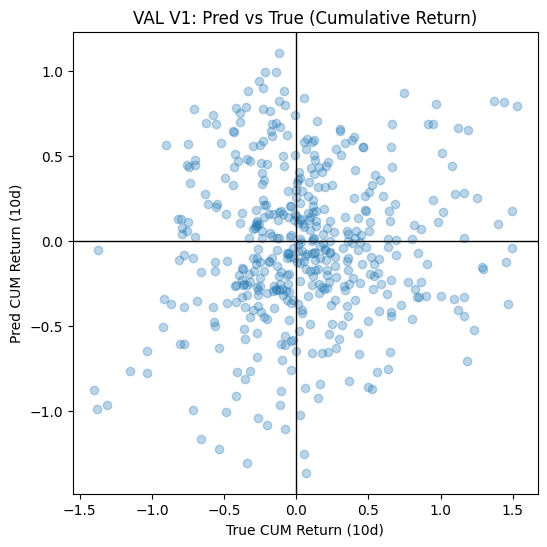

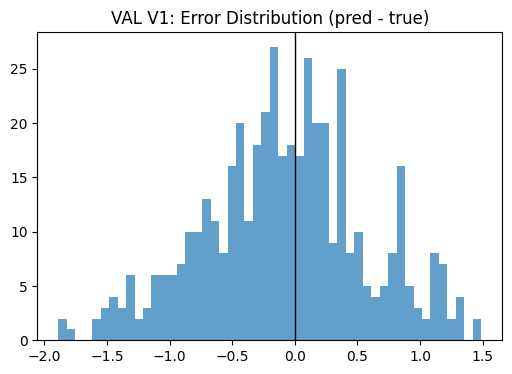

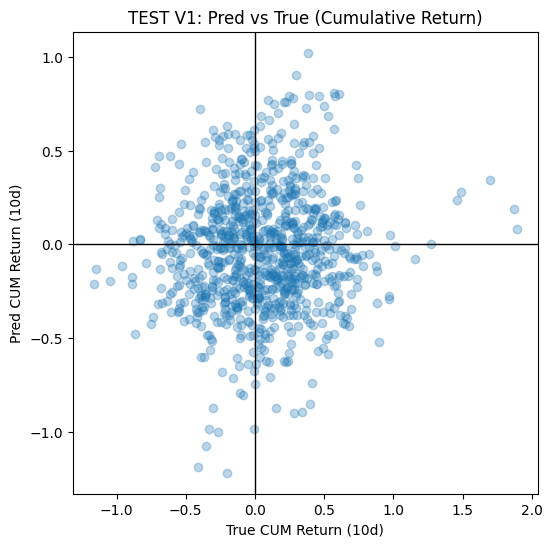

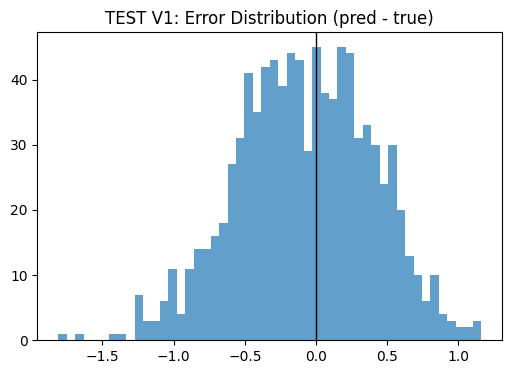

In [35]:
# 1) Collect returns for val & test
val_true_cum, val_pred_cum, val_naive_cum = collect_cum_returns(val_loader_global, name="val")
test_true_cum, test_pred_cum, test_naive_cum = collect_cum_returns(test_loader_global, name="test")

# 2) Plot
plot_scatter_and_error(val_true_cum, val_pred_cum, name="VAL V1")
plot_scatter_and_error(test_true_cum, test_pred_cum, name="TEST V1")


In [25]:
import torch
torch.cuda.empty_cache()
# 필요하면
del model